# Code

## Imports

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

## Functions

### Price Oil Data

In [34]:
def price(df):
    # Create a Calendar Data Frame to fill all days in range and its metrics as weekdays
    Calendar = pd.DataFrame([pd.date_range(start = '1/1/2013', end = '31/8/2017'),pd.date_range(start = '1/1/2013', end = '31/8/2017').dayofweek], index = ['date', 'weekday']).T
    date_price = []
    #Create a data with the needed values
    for i in Calendar.index:
        date = str(Calendar['date'][i]).split()[0]
        weekday = Calendar['weekday'][i]
        # add in data the Oil Price Values. If it exist in the previous given data, just add.
        #On the oder hand, if it isn't in the previou given data, add as NaN
        if date in df.index:
            date_price.append([date, float(df.loc[date]), weekday ])
        else:
            date_price.append([date, np.nan, weekday])
    #Create and set the Price Data Frame
    Price = pd.DataFrame(date_price, columns = 'date price weekday'.split())
    Price.set_index('date', inplace = True)
    
    #Add new infos to the Price Data Frame
    #relative_ydate: Its the day of year, 0 is the first day of that year and 364 is the last one in case of non Leap Year.
    relative_ydate = []
    #relative_date: Its the relative day in reference of the first day in data (2013-01-01)
    relative_date = []
    #year: the respctive year
    year = []
    t = 0
    p = 0
    for i in range (len(Price.index.tolist())):
        relative_date.append(t)
        t += 1
        
        if Price.index[i].split('-')[1] == '01' and Price.index[i].split('-')[2] == '01':
            p = 0
        relative_ydate.append(p)
        p += 1
        
        year.append(Price.index[i].split('-')[0])
        
    #add those infos in Price Data Frame     
    Price['date_rel'] = relative_date
    Price['day_of_year'] = relative_ydate
    Price['year'] = year
    return Price

### Days Off

Create a Data with the Days Off in Holidays_Events.csv. 
Work days and events are not included in this data

In [35]:
def days_off (df):
    #classify the days that was day_off
    Bol = (df['type'] == 'Holiday') | (df['type'] == 'Additional') | (df['type'] == 'Bridge')
    Days_Off = df[Bol].copy()
    #change the days of holidays that was transfered to the transfered date
    for i in Days_Off.index:
        if Days_Off['transferred'][i] == True:
            desc = Days_Off['description'][i]
            year = Days_Off['date'][i].split('-')[0]

            Bol = df['type'] == 'Transfer'
            for c in df[Bol].index:
                if df[Bol]['description'][c].find(desc) >= 0:
                    if df[Bol]['date'][c].split('-')[0] == year:
                        Days_Off['date'][i] = df[Bol]['date'][c]
    return Days_Off

### Days With No Data

Create a list to show the missing dates that is not a Day Off

In [36]:
def days_missing(df_data, df_holidays):
    #Find Missing Data
    Bol = df_data['price'].isna()
    days = []
    for i in df_data[Bol].index:
        #Exclude the days that where Holidays
        if i in df_holidays['date'].tolist():
            m = 0
        else:
        #Exclude weekend days of the analysis
            if df_data[Bol]['weekday'][i] < 5:
                days.append(i)
    return days

### Set Data with important infos

Add in Train and Test Data some classification as store type, and some important infos as Oil Price and dates in others formats

In [37]:
def set_data(df):
    
    #Set the categories to add as a number
    family_names = df[~df['family'].duplicated(keep = 'first')]['family'].tolist()
    store_types = 'A B C D E'.split()
    
    
    price_Oil = np.zeros((df.shape[0], 1))
    family_nums = np.zeros((df.shape[0], 1))
    store_type = np.zeros((df.shape[0], 1))
    acu_day = np.zeros((df.shape[0], 1))
    
    #add data to the Train Data
    for i in df.index:
        date = df['date'][i]
        store =  df['store_nbr'][i]
        price_Oil[i,0] += Price['price'][date]
        family_nums[i,0] += family_names.index(df['family'][i])
        store_type [i,0] += store_types.index(Stores['type'][store])
        acu_day [i,0] += Price['date_rel'][date]

    df['oil_price'] = price_Oil
    df['family_num'] = family_nums
    df['store_type'] = store_type
    df['acumulative_day'] = acu_day
    return df

### Set Test Data with important infos

The same ideia of set_train function, however there is a peculiarity to acumulative days, because there

In [38]:
def set_test(df):
    family_names = df[~df['family'].duplicated(keep = 'first')]['family'].tolist()
    store_types = 'A B C D E'.split()
    price_Oil = np.zeros((df.shape[0], 1))
    family_nums = np.zeros((df.shape[0], 1))
    store_type = np.zeros((df.shape[0], 1))

    for i in df.index:
        date = df['date'][i]
        store =  df['store_nbr'][i]
        price_Oil[i,0] += Price['price'][date]
        family_nums[i,0] += family_names.index(df['family'][i])
        store_type [i,0] += store_types.index(Stores['type'][store])
        
        
    date = df[~df['date'].duplicated(keep = 'first')]['date'].to_list()
    acumulative_day = np.zeros((len(date), 1))
    t = Train['acumulative_day'].max() + 1
    for i in range(len(date)):
        acumulative_day[i,0] += t
        t += 1
    Days = pd.DataFrame( acumulative_day, columns = ['acumutalive_day'])
    Days['date'] = date
    Days.set_index('date', inplace = True)
    day_rel = np.zeros((df.shape[0], 1))
    for j in df.index:
        day = df['date'][j]
        day_rel[j,0] += Days['acumutalive_day'][day]
    

    df['oil_price'] = price_Oil
    df['family_num'] = family_nums
    df['store_type'] = store_type
    df['acumulative_day'] = day_rel
    return df

## Application

Create the Oil Price Data

In [39]:
Oil = pd.read_csv('oil.csv', header = 0,names = 'date price'.split() ,index_col = 'date')

In [40]:
Price = price(Oil)
Price.head()

,price,weekday,date_rel,day_of_year,year
date,,,,,
2013-01-01,NaN,1,0,0,2013
2013-01-02,93.14,2,1,1,2013
2013-01-03,92.97,3,2,2,2013
2013-01-04,93.12,4,3,3,2013
2013-01-05,NaN,5,4,4,2013


Analysis the Days Off

In [41]:
Holidays = pd.read_csv('holidays_events.csv')

In [42]:
Days_Off =  days_off(Holidays)
Days_Off.head()

<ipython-input-35-235c79f7b342>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Days_Off['date'][i] = df[Bol]['date'][c]


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


Find the days that is not Day Off and the value of the Oil Price is missing

In [43]:
N_days_miss = days_missing(Price, Days_Off)
N_days_miss

['2013-01-21',
 '2013-02-18',
 '2013-03-29',
 '2013-05-27',
 '2013-07-04',
 '2013-09-02',
 '2013-11-28',
 '2014-01-20',
 '2014-02-17',
 '2014-05-26',
 '2014-07-04',
 '2014-09-01',
 '2014-11-27',
 '2015-01-19',
 '2015-05-25',
 '2015-09-07',
 '2015-11-26',
 '2016-01-18',
 '2016-02-15',
 '2016-05-30',
 '2016-07-04',
 '2016-09-05',
 '2016-11-24',
 '2017-01-16',
 '2017-02-20',
 '2017-05-29',
 '2017-07-04']

## Hypoteses

The Oil Price is freezing in Day Off, so its value is the last mensured value

In [44]:
Price.ffill(inplace = True)

The normal days with missing values, a linear interpolation was the best fit found

In [45]:
for i in N_days_miss:
    idx = Price.index.tolist().index(i)
    xp = [Price.iloc[idx - 1]['date_rel'], Price.iloc[idx+1]['date_rel']]
    fp = [Price.iloc[idx - 1]['price'], Price.iloc[idx+1]['price']]
    Price.iloc[idx]['price'] = np.interp(Price.iloc[idx]['date_rel'], xp, fp)

<ipython-input-45-5dc3834491b2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Price.iloc[idx]['price'] = np.interp(Price.iloc[idx]['date_rel'], xp, fp)


## Plot Oil Price in time

This show how the Price Oil behaved in time series, and the conclusion is that in 2015 something affected the Oil Price and it becomed sateady

Text(0.5, 0, 'Day')

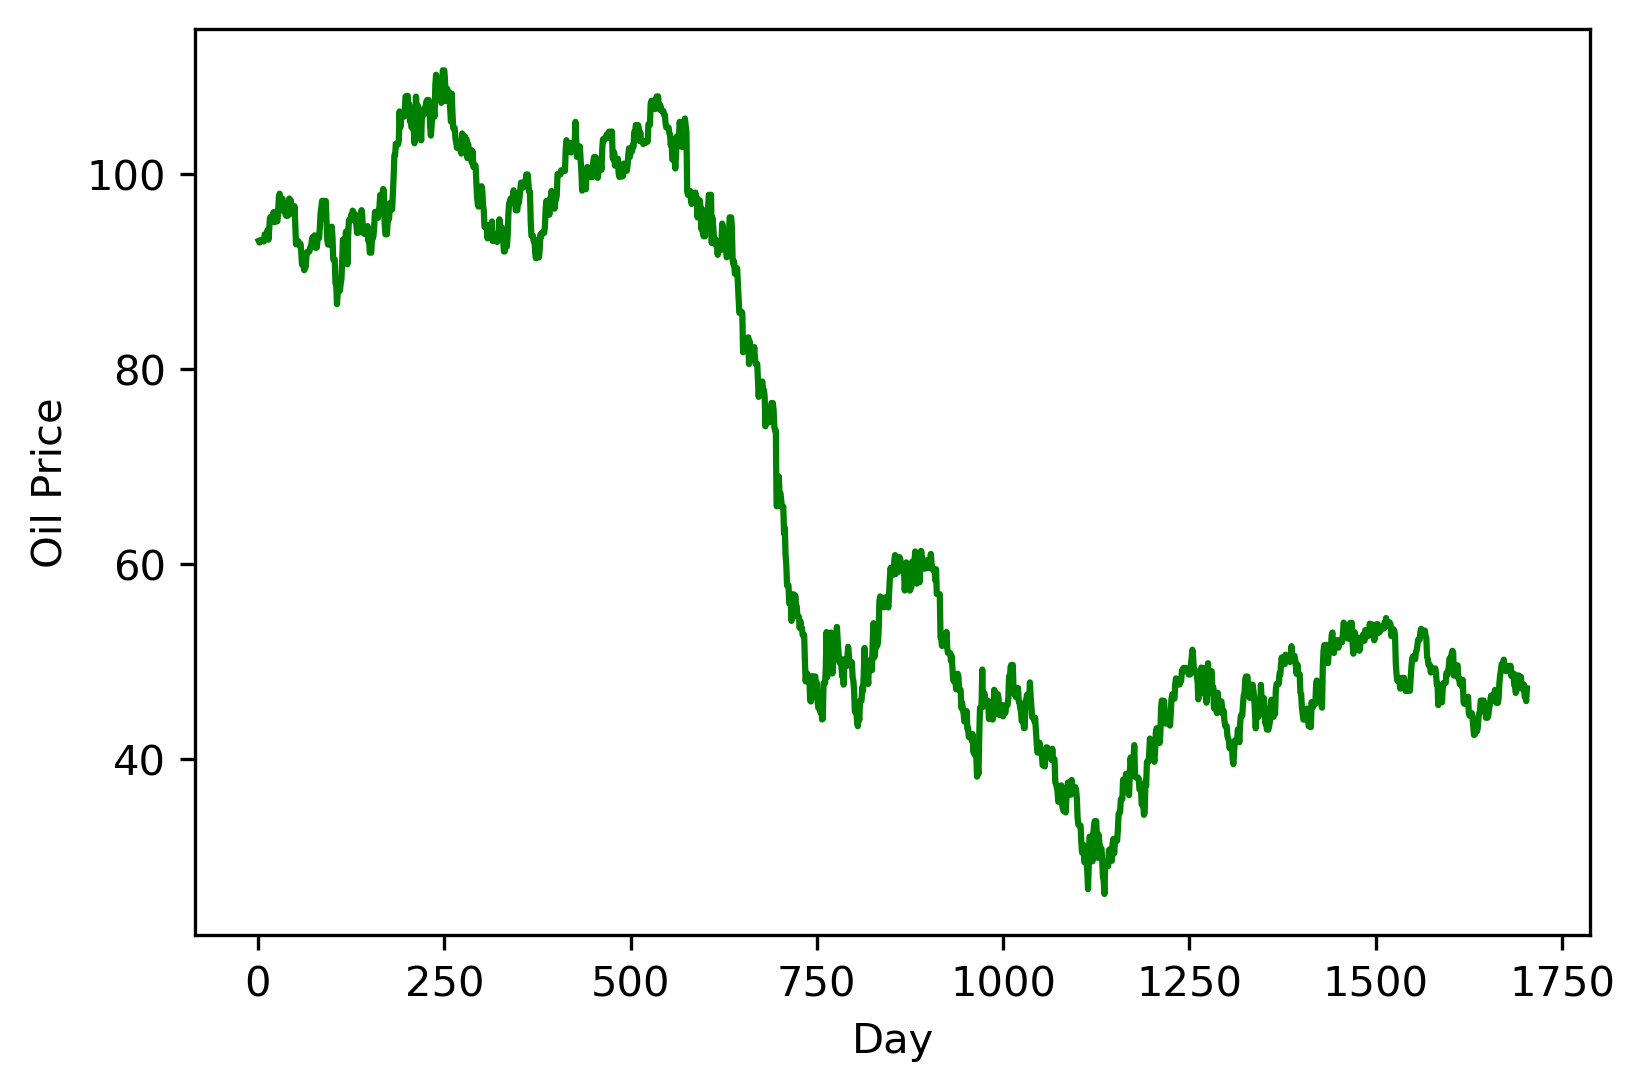

In [16]:
fig, ax = plt.subplots(dpi = 300)
ax.plot(Price['date_rel'],Price['price'], color = 'g')
ax.set_ylabel('Oil Price')
ax.set_xlabel('Day')

## Import Others Data Set

In [17]:
Transactions = pd.read_csv('transactions.csv')
Transactions.set_index('date', inplace = True)

In [18]:
Stores = pd.read_csv('stores.csv')
Stores.set_index('store_nbr', inplace = True)

## Set Train Date and Anylise

In [25]:
Train = pd.read_csv('train.csv')
Train = set_data(Train)

Find the average sales per day, and it is not consider the difference between store, location or product family

In [26]:
Avg_Sales = Train.groupby('date')['sales'].mean().to_frame()

Plot the Average Sales in relation of time and point the Days Off to show tha sazonality

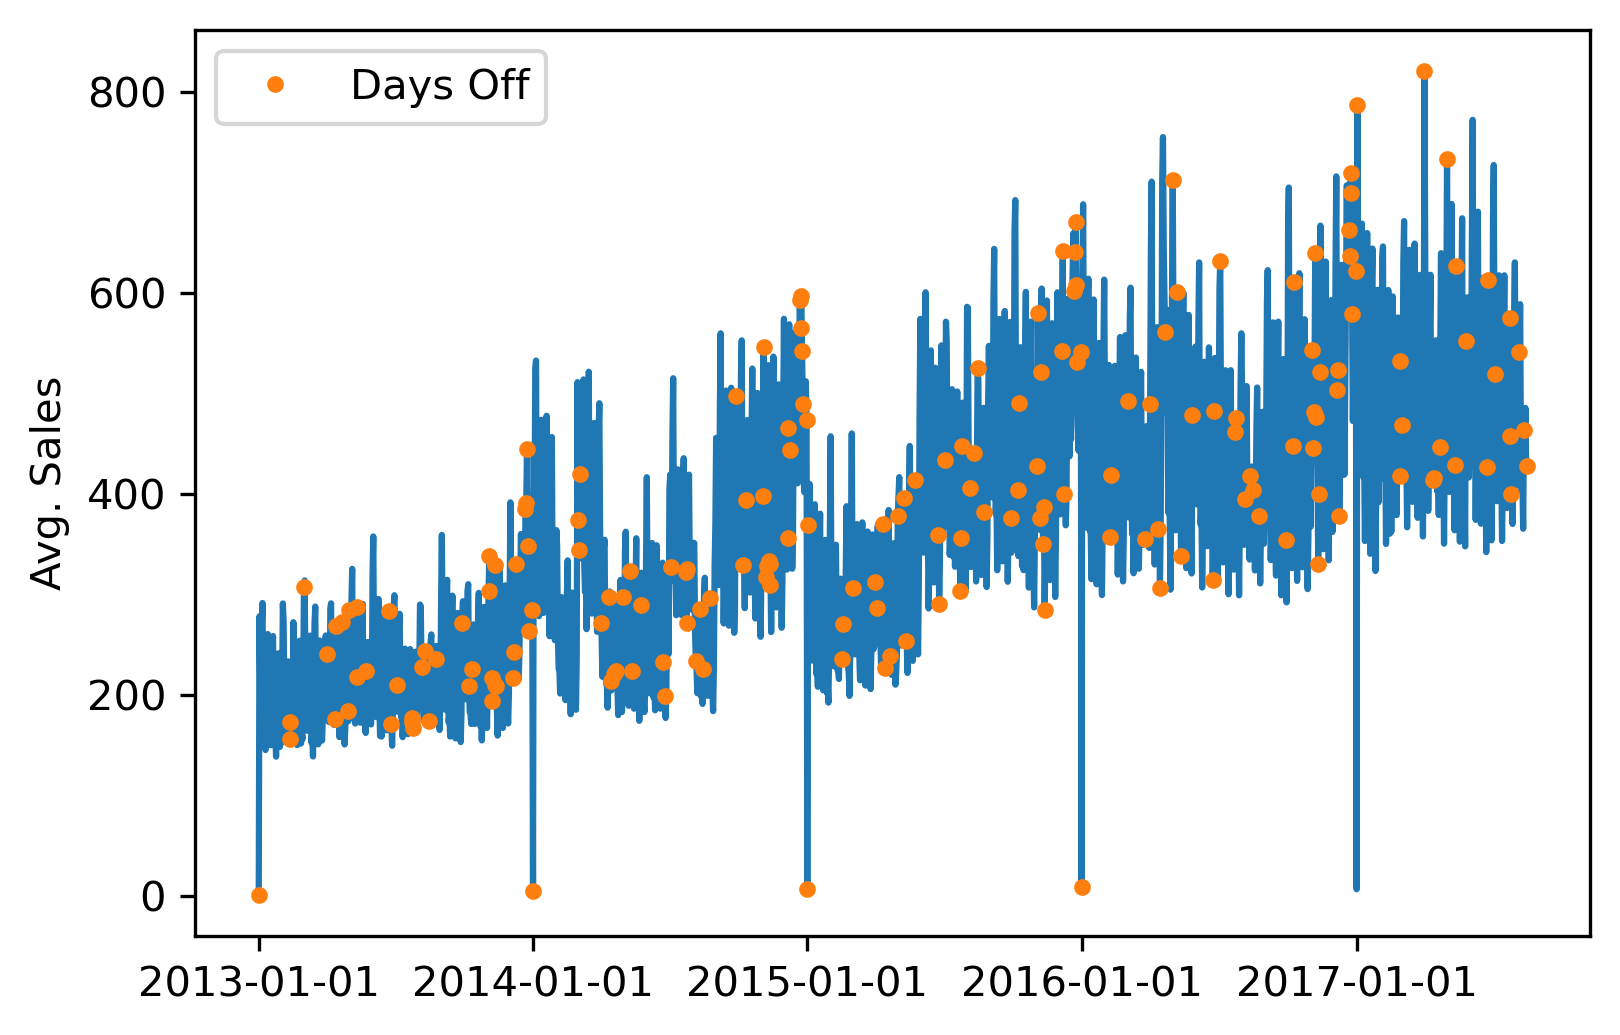

In [27]:
fig, ax = plt.subplots(dpi = 300)
ax.plot(Avg_Sales['sales'])
ax.plot(Avg_Sales[Avg_Sales.index.isin(Days_Off['date'])], linestyle = ' ', marker = '.', label = 'Days Off')
ax.set_xticks(['2013-01-01', '2014-01-01', '2015-01-01', '2016-01-01', '2017-01-01'])
ax.set_ylabel('Avg. Sales')
plt.legend()

The graph showed that sazonality is important, because Day_Off appered in a lot of peaks and valleys

## Read the Test Data

In [28]:
Test = pd.read_csv('test.csv')
Test = set_data(Test)

## Linear Regression

### Hypoteses

Although sazonality showed its importance in this time series, this model is not consider sazonality.

It is not consider how the Oil Price affects the sales

It is not consider the Transactios that affect the average ticket for each store and product family

### Linear Regression Model 

This Linear Regression Model was mad for each type of store and for each product family

So the predicit is made with the store and product classification

In [29]:
#Result Matrix is maden to add each kind of prediction in the Test Date 
Results = np.zeros((Test.shape[0],1))
#Made a prediction for each store type and family
for i in range(int(Train['store_type'].max())):
    for j in range(int(Train['family_num'].max())):
        Bol1 = Train['store_type'] == i
        Bol2 = Train['family_num'] == j
        #The train data follow the filters
        X_Train = np.array(Train[Bol1 & Bol2]['acumulative_day']).reshape(-1,1)
        Y_Train = np.array(Train[Bol1 & Bol2]['sales']).reshape(-1,1)
        Model = linear_model.LinearRegression()
        #A model is create for the specific filter
        Model.fit(X_Train, Y_Train)
        
        #The same is maden to the Test Data
        Bol3 = Test['store_type'] == i
        Bol4 = Test['family_num'] == j
        #So it is possible to predict the data for the specif case
        X_Test = np.array(Test[Bol3 & Bol4]['acumulative_day']).reshape(-1,1)
        Y_Test = Model.predict(X_Test)
        
        #This add the results in the right index to be compiled in the Test Data
        for c in range(Test[Bol3 & Bol4].shape[0]):
            index = Test[Bol3 & Bol4].index[c]
            Results[index, 0] += pd.DataFrame(Y_Test).iloc[c][0]
Test['sale'] = Results

In [30]:
# The Submission According to Kaggle
Submission = pd.read_csv('sample_submission.csv')
Submission.set_index('id', inplace = True)
Submission['sales'] = Test['sale']

In [89]:
Test.tail()

,id,date,store_nbr,family,onpromotion,oil_price,family_num,store_type,acumulative_day,sale
28507,3029395,2017-08-31,9,POULTRY,1,47.26,28.0,1.0,1703.0,303.633617
28508,3029396,2017-08-31,9,PREPARED FOODS,0,47.26,29.0,1.0,1703.0,92.839637
28509,3029397,2017-08-31,9,PRODUCE,1,47.26,30.0,1.0,1703.0,1671.553357
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9,47.26,31.0,1.0,1703.0,8.231113
28511,3029399,2017-08-31,9,SEAFOOD,0,47.26,32.0,1.0,1703.0,0.000000


# Conclusion and Considers

I haven't any experience with Machine Learning Models and how it's built, however this it was a challange for me and improved my skills in data. I would like to point some skills improved with this challange: 

- New Pandas Functions for me

- New data interpretation

- Knowledg about Time Series

- First time to use SKLearn

- Meet news methods as ARIMA and its variations as SARIMA in spite of I couldn't apply here

- Time Series Split Type, as the last topic, I couldn't apply here too

- Code thinking how viewers will read it

## Difficults

I would like to point some difficults that I had during this challange

- Pandas Skill: Something that I need work often to take more expertise

- ML Methods: I need to learn more and practice more to know the best for it case and apply correctly

- ML Knowledge: I need to understand more the theory and understand the applications and how it works

## Future Improves For This Chalange

- I would like to use the SARIMA method, because this challange has a lot of variables and there is the sazonality

- I would like to understand more how the transactions would affect the prevision

- I would like to do analysis usind the weekdays to understand the consummer behavior

- I would like to understand more how the oil price affects each product family for a more conscintence predict